# Needed for consistently measuring RVs.
To consistently measure the RVs of my target stars, I need to align them with the telluric lines. That is because I took no effort to make sure they are consistent by e.g. observing an RV standard or something. I have a decent amount of code already written for the IGRINS pipeline, so lets just re-use that.

## Status as of end of day Thusday, Sep 3:
  - Seems to work. Need to go through and apply to all of my stars I guess?
  - How stable is the rv fit?
  - Is it the same for all echi files that go into the final ones?
  - Need to keep track of the velocity changes to include in the companion velocities (or just re-run the ccf analysis on the new files)

In [23]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import HelperFunctions
import telfit
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import FittingUtilities
from scipy.optimize import minimize
from functools import partial

home = os.environ['HOME']
sys.path.append('{}/School/Research/IGRINS_data/plp/recipes/'.format(home))
import recipe_tell_wvsol

%matplotlib inline

In [3]:
orders = HelperFunctions.ReadExtensionFits('../20150520/echi150520.1168-0.fits')

In [26]:
# Make a telluric model
modeler = telfit.Modeler()
lowfreq = 1e7/(orders[-1].x[-1]+2)
highfreq = 1e7/(orders[0].x[0]-2)
original_model = modeler.MakeModel(lowfreq=lowfreq, highfreq=highfreq)

In [30]:
# Reduce the resolution on the telluric model
new_x = np.logspace(np.log(original_model.x[0]), np.log(original_model.x[-1]), original_model.size(), base=np.e)
full_model = FittingUtilities.RebinData(original_model, new_x)
full_model = FittingUtilities.ReduceResolutionFFT(full_model, 110000)

# Interpolate the telluric model
telluric = spline(full_model.x, full_model.y)

Warning, 1233 of 2871405 bins contained negative fluxes; they have been set to zero.


In [77]:
c = 3e5
new_telluric = lambda tell, alpha, x: tell(x)**alpha
def lnlike(pars, data_orders, modelfcn):
    rv, alpha = pars
    new_modelfcn = partial(new_telluric, modelfcn, alpha)
    ll = 0.0
    for order in data_orders:
        x = order.x*(1+rv/c)
        y = order.y / order.cont
        e = order.err / order.cont
        ll += -0.5 * np.sum((y - new_modelfcn(x))**2 / e**2 + np.log(2*np.pi*(e**2)))
    print rv, alpha, ll
    return ll

def errfcn(pars, data_orders, modelfcn):
    return -lnlike(pars, data_orders, modelfcn)

0.0 0.65 53108.845813
1e-08 0.65 53108.845434
0.0 0.65000001 53108.8529397
-5.0 2.0 -2984668.85481
-4.99999999 2.0 -2984668.84854
-5.0 2.00000001 -2984668.86242
-0.419179575231 0.763178485312 72417.650971
-0.419179565231 0.763178485312 72417.6519849
-0.419179575231 0.763178495312 72417.6505778
-0.162479737944 0.748288425627 88212.0163308
-0.162479727944 0.748288425627 88212.0165323
-0.162479737944 0.748288435627 88212.0166086
-0.084589816319 0.771663815674 88018.0894648
-0.084589806319 0.771663815674 88018.0894215
-0.084589816319 0.771663825674 88018.0885244
-0.126997628208 0.758936891275 88714.3071389
-0.126997618208 0.758936891275 88714.3072274
-0.126997628208 0.758936901275 88714.3068437
-0.0996002429018 0.753531217797 88917.2069015
-0.0996002329018 0.753531217797 88917.2069018
-0.0996002429018 0.753531227797 88917.2068984
-0.0995189712424 0.753474229633 88917.2164848
-0.0995189612424 0.753474229633 88917.2164848
-0.0995189712424 0.753474239633 88917.2164848
-0.0995186815137 0.75347

<IPython.core.display.Javascript object>


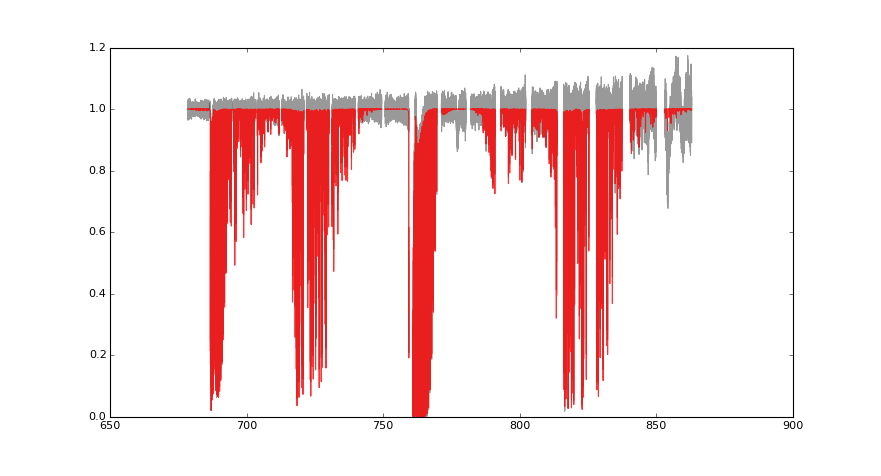

In [81]:
rv_vals = np.linspace(-2, 2, 20)
ll = np.empty_like(rv_vals)
modelfcn = partial(new_telluric, telluric, 0.65)
out = minimize(errfcn, [0.0, 0.65], args=(orders[40:], telluric), bounds=((-5, 5), (0, 2)))
rv, alpha = out.x
modelfcn = partial(new_telluric, telluric, alpha)
print('Best RV = {}\nBest alpha = {}'.format(rv, alpha))

%matplotlib nbagg
for order in orders[40:]:
    x = order.x*(1+rv/c)
    y = order.y / order.cont
    plt.plot(x, y, 'k-', alpha=0.4)
    plt.plot(x, modelfcn(x), 'r-', lw=1, alpha=0.8)
    

<IPython.core.display.Javascript object>


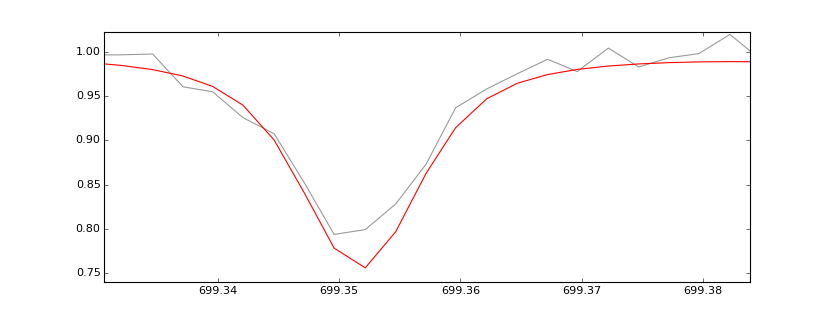

In [72]:
%matplotlib nbagg
#import matplotlib
#print matplotlib.__version__
rv = out.x
modelfcn = partial(new_telluric, telluric, 0.7)
for order in orders[40:]:
    x = order.x*(1+rv/c)
    y = order.y / order.cont
    plt.plot(x, y, 'k-', alpha=0.4)
    plt.plot(x, modelfcn(x), 'r-', lw=1)

In [28]:
new_telluric = lambda tell, alpha, x: tell(x)**alpha
def errfcn(alpha, data, modelfcn):
    model = modelfcn(data[0])**alpha
    return np.sum((data[1] - model)**2)

def adjust_telluric(data, modelfcn):
    out = minimize(errfcn, 1.0, args=(data, modelfcn))
    print('best-fit alpha = {}'.format(out.x[0]))
    return partial(new_telluric, modelfcn, out.x)
    

def optimize_order_wavelength(data_original, modelfcn, fitorder=3, be_safe=True, N=5):
    """
    Runs fit_wavelength N times.
    """
    data = data_original.copy()
    if len(data[0]) < 100 or min(modelfcn(data[0])) > 0.90:
        return None
    for i in range(N):
        data = recipe_tell_wvsol.fit_wavelength(data.copy(), modelfcn, fitorder=fitorder, be_safe=be_safe)
        modelfcn = adjust_telluric(data, modelfcn)
    return data

<IPython.core.display.Javascript object>


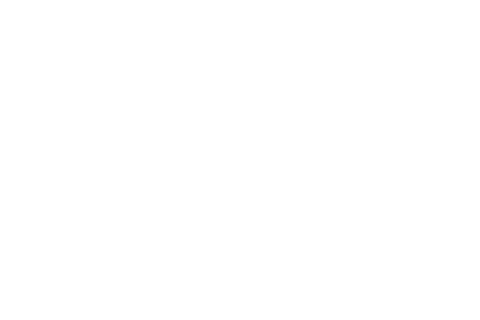

best-fit alpha = 0.618490020271
best-fit alpha = 0.999980880489
best-fit alpha = 1.0
best-fit alpha = 0.618478232672


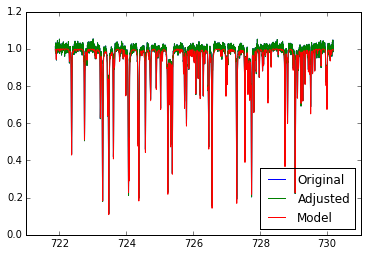

In [51]:
order = orders[45]

%matplotlib notebook
plt.plot(order.x, order.y/order.cont, label='Original')
data = np.array((order.x, order.y/order.cont))
new_data = optimize_order_wavelength(data, telluric, fitorder=2, N=3)
plt.plot(new_data[0], new_data[1], label='Adjusted')
tmp = adjust_telluric(new_data, telluric)
plt.plot(new_data[0], tmp(new_data[0]), label='Model')
plt.legend(loc='best')


best-fit alpha = -8.51412775255
best-fit alpha = 2.64408906474
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 95.1839738425
best-fit alpha = 1.06234826426
best-fit alpha = 1.00018016219
best-fit alpha = 1.00073632697
best-fit alpha = 1.00018106827
best-fit alpha = 4.96573187402
best-fit alpha = 1.00599432777
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 2.87349282588
best-fit alpha = 1.00121933894
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 12.856317211
best-fit alpha = 1.01607647724
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0
best-fit alpha = 1.0129699707
best-fit alpha = 10.0770510915
best-fit alpha = 3.70417282722
best-fit alpha = 1.0
best-fit alpha = 1.00270271301
best-fit alpha = 428.411329499
best-fit alpha = 1.00728521809
best-fit alpha = 1.00102903124
best-fit alpha = 1.00062180281
best-fit alpha = 1.00001848323
best-fit alpha = 172.339973737
best-fit alpha 

<IPython.core.display.Javascript object>


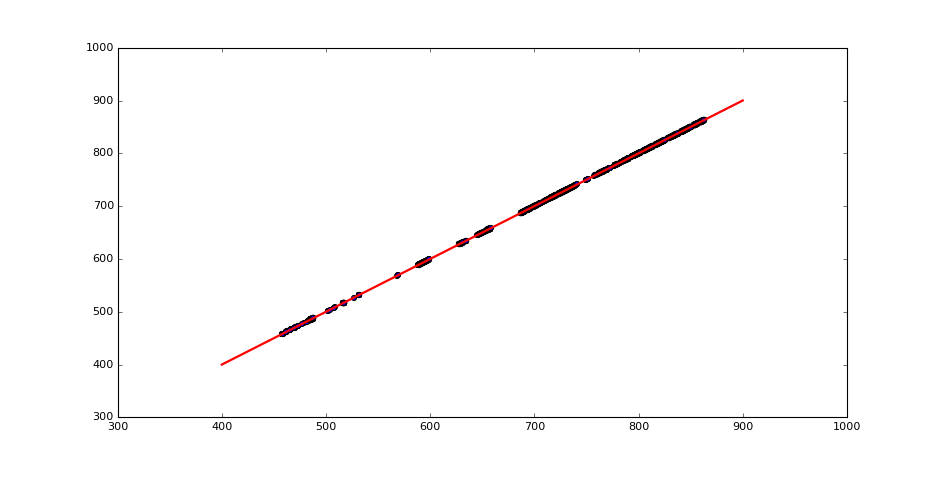

In [36]:
old_waves = []
new_waves = []
weights = []
for order in orders:
    data = np.array((order.x, order.y/order.cont))
    new_data = optimize_order_wavelength(data, telluric)
    if new_data is not None:
        lines = FittingUtilities.FindLines(order, tol=0.90)
        if len(lines) < 1:
            continue
        old_waves.append(data[0][lines])
        new_waves.append(new_data[0][lines])
        weights.append(1.0 - data[1][lines])

old_waves = np.hstack(old_waves)
new_waves = np.hstack(new_waves)
weights = np.hstack(weights)

%matplotlib notebook
plt.scatter(old_waves, new_waves)
plt.plot(plt.xlim(), plt.ylim(), 'r-', lw=2)

In [43]:
v = (old_waves - new_waves)/new_waves * 3e5
print np.mean(v), np.median(v), np.std(v)

0.503338472207 0.0459732892819 10.7078170589


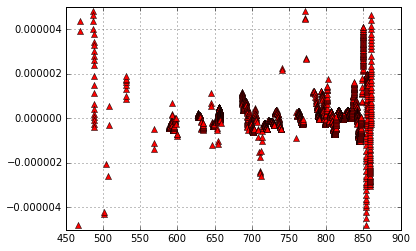

In [49]:
plt.plot(new_waves, (old_waves-new_waves)/old_waves, 'r^')
plt.ylim((-5e-6, 5e-6))
plt.grid()